
# EDA – Données météo IDF (Couche Silver)

Ce notebook explore le fichier **`data/silver/time_series/meteo_clean.parquet`** généré par la couche *Silver* :
- contrôle qualité et couverture
- saisonnalité et distributions
- identification d'épisodes pluvieux **intenses** (seuil par station, p95)
- préparation de **seuils** et artefacts utiles pour la couche *Gold* (ML météo-only)

> Le fichier contient ~3.7M lignes ; certaines cellules peuvent prendre du temps. Les visuels utilisent **matplotlib** (pas de dépendances exotiques).


## Chargement et configuration

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path("data/silver/time_series/meteo_clean.parquet")
assert DATA_PATH.exists(), f"Fichier introuvable: {DATA_PATH}"

df = pd.read_parquet(DATA_PATH)

# garde un sous-ensemble utile si présent
keep = [c for c in ["NUM_POSTE","NOM_USUEL","date","RR","RR_7d","RR_14d","RR_30d",
                    "API","TM","TM_7d","TM_30d","PMER","FFM","day_of_year","month","year"]
        if c in df.columns]
df = df[keep].copy()

# types / dates
df["date"] = pd.to_datetime(df["date"], errors="coerce")

if "year" not in df.columns:
    df["year"] = df["date"].dt.year
if "month" not in df.columns:
    df["month"] = df["date"].dt.month

print(df.shape, list(df.columns)[:20])


(2272576, 11) ['NUM_POSTE', 'NOM_USUEL', 'date', 'RR', 'RR_7d', 'RR_14d', 'RR_30d', 'API', 'day_of_year', 'month', 'year']


## 1. Nombre d’observations par année

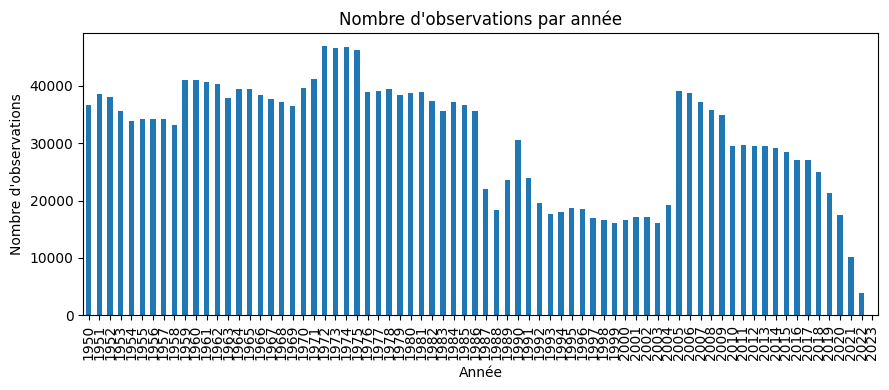

In [13]:
year_counts = df.groupby("year")["date"].count().sort_index()

plt.figure(figsize=(9,4))
year_counts.plot(kind="bar")
plt.title("Nombre d'observations par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'observations")
plt.tight_layout()
plt.show()


# 2.Top 20 stations par volume de données

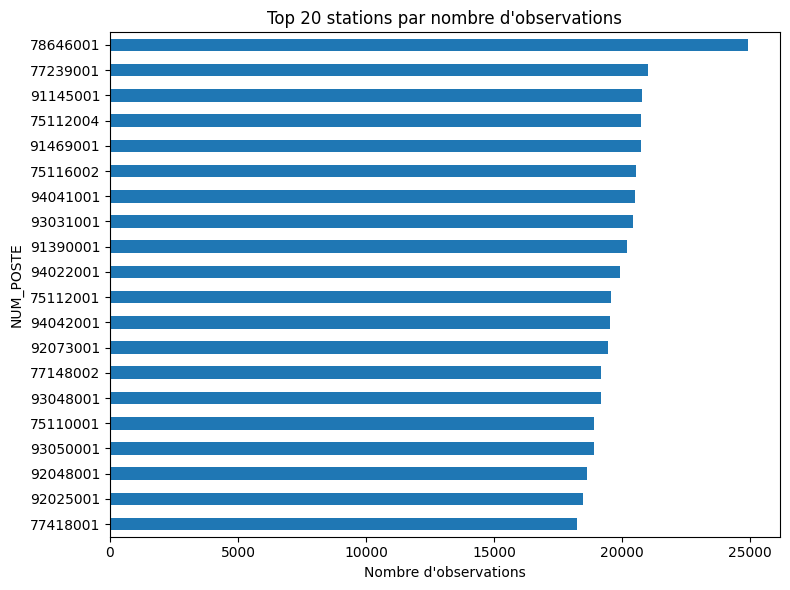

In [14]:
if "NUM_POSTE" in df.columns:
    topN = (df.groupby("NUM_POSTE")["date"]
              .count()
              .sort_values(ascending=False)
              .head(20))

    plt.figure(figsize=(8,6))
    topN[::-1].plot(kind="barh")  # ordre croissant pour lisibilité
    plt.title("Top 20 stations par nombre d'observations")
    plt.xlabel("Nombre d'observations")
    plt.ylabel("NUM_POSTE")
    plt.tight_layout()
    plt.show()


## 3. Taux de valeurs manquantes (top 15 colonnes)

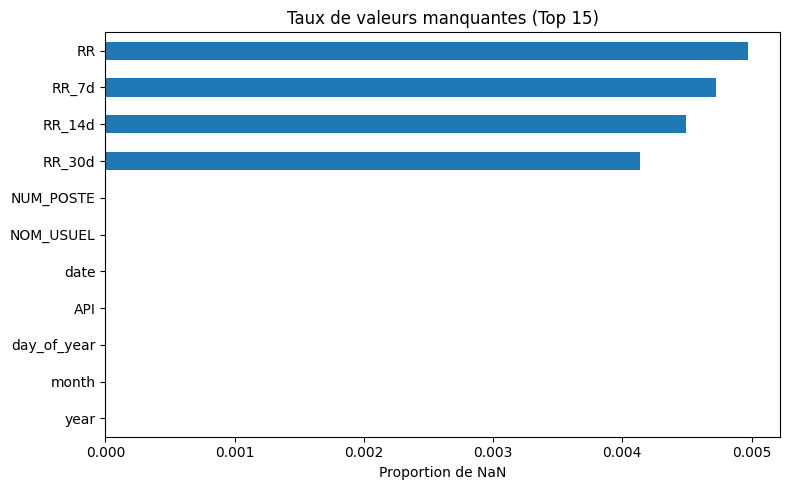

In [15]:
na_ratio = df.isna().mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
na_ratio[::-1].plot(kind="barh")
plt.title("Taux de valeurs manquantes (Top 15)")
plt.xlabel("Proportion de NaN")
plt.tight_layout()
plt.show()


## 4. Distribution de RR (mm) — clip à 100 mm

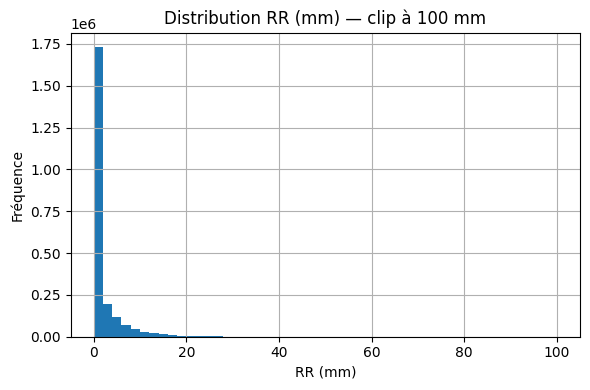

In [18]:
if "RR" in df.columns:
    rr = df["RR"].dropna().clip(upper=100)

    plt.figure(figsize=(6,4))
    rr.hist(bins=50)
    plt.title("Distribution RR (mm) — clip à 100 mm")
    plt.xlabel("RR (mm)")
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()


## 5. Distribution de RR\_7d (mm) — clip à 200 mm

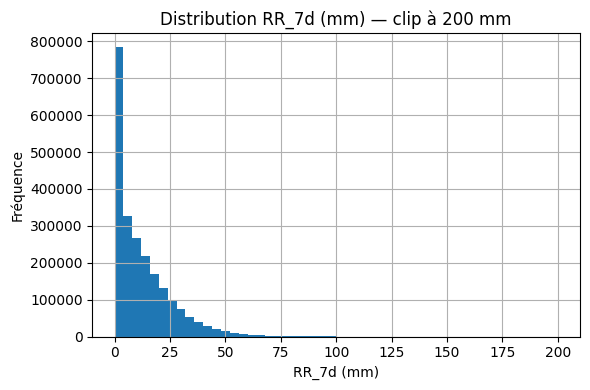

In [19]:
if "RR_7d" in df.columns:
    rr7 = df["RR_7d"].dropna().clip(upper=200)

    plt.figure(figsize=(6,4))
    rr7.hist(bins=50)
    plt.title("Distribution RR_7d (mm) — clip à 200 mm")
    plt.xlabel("RR_7d (mm)")
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()


## 6. RR\_7d et API — station la plus fournie

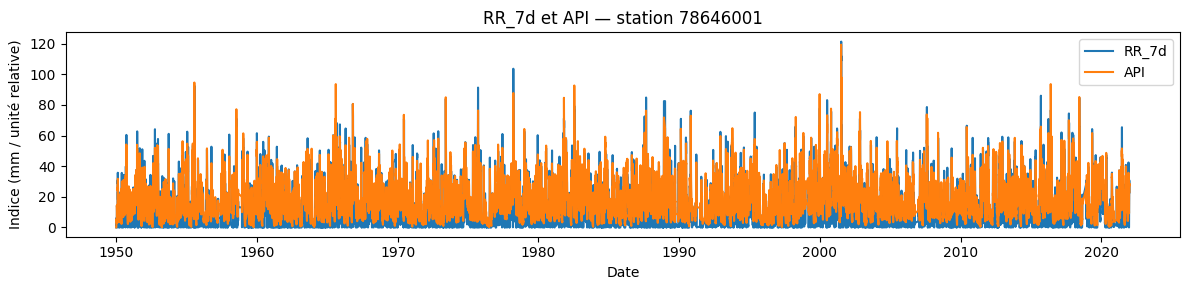

In [21]:
if "NUM_POSTE" in df.columns and ("RR_7d" in df.columns or "API" in df.columns):
    st = (df.groupby("NUM_POSTE")["date"].count().sort_values(ascending=False).index[0])
    s = df[df["NUM_POSTE"]==st].sort_values("date")

    plt.figure(figsize=(12,3))
    if "RR_7d" in s.columns:
        plt.plot(s["date"], s["RR_7d"], label="RR_7d")
    if "API" in s.columns:
        plt.plot(s["date"], s["API"], label="API")
    plt.title(f"RR_7d et API — station {st}")
    plt.xlabel("Date")
    plt.ylabel("Indice (mm / unité relative)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 7. RR moyen par mois (toutes années)

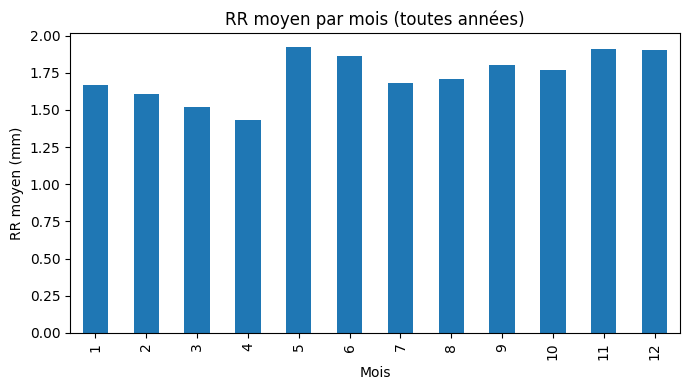

In [22]:
if "RR" in df.columns:
    monthly = df.groupby("month")["RR"].mean()

    plt.figure(figsize=(7,4))
    monthly.plot(kind="bar")
    plt.title("RR moyen par mois (toutes années)")
    plt.xlabel("Mois")
    plt.ylabel("RR moyen (mm)")
    plt.tight_layout()
    plt.show()


## 8. Part des jours de pluie (RR ≥ 1 mm) par année

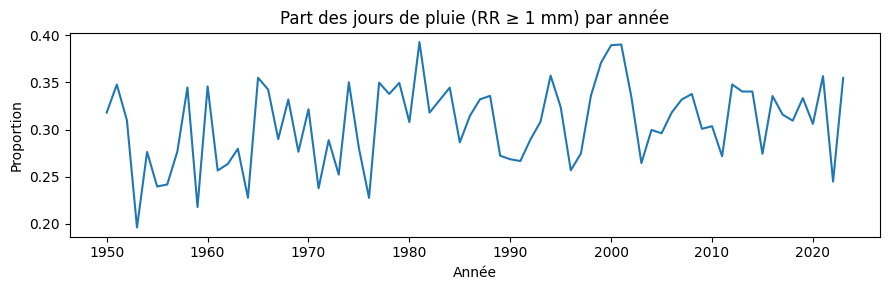

In [23]:
if "RR" in df.columns:
    daily = df.dropna(subset=["date"]).copy()
    daily["is_rain"] = (daily["RR"] >= 1.0).astype(int)

    by_year = (daily.groupby("year")["is_rain"]
                    .mean()
                    .sort_index())

    plt.figure(figsize=(9,3))
    plt.plot(by_year.index, by_year.values)
    plt.title("Part des jours de pluie (RR ≥ 1 mm) par année")
    plt.xlabel("Année")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()


# 9. Part des jours de pluie forte par année (RR ≥ 10 mm)

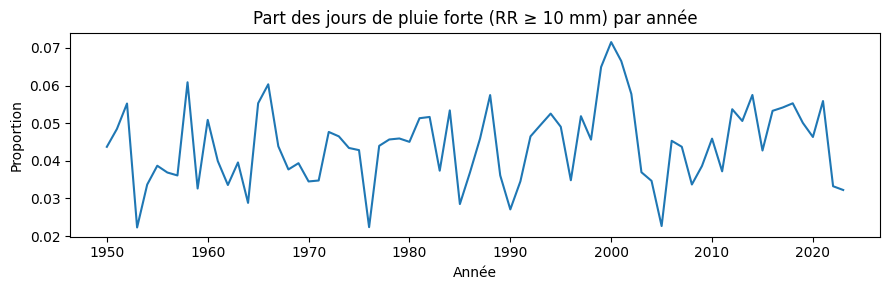

In [24]:
if "RR" in df.columns:
    daily = df.dropna(subset=["date"]).copy()
    daily["is_heavy"] = (daily["RR"] >= 10.0).astype(int)

    by_year_heavy = (daily.groupby("year")["is_heavy"]
                         .mean()
                         .sort_index())

    plt.figure(figsize=(9,3))
    plt.plot(by_year_heavy.index, by_year_heavy.values)
    plt.title("Part des jours de pluie forte (RR ≥ 10 mm) par année")
    plt.xlabel("Année")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()


# 10. R moyen par jour de l’année (climatologie)

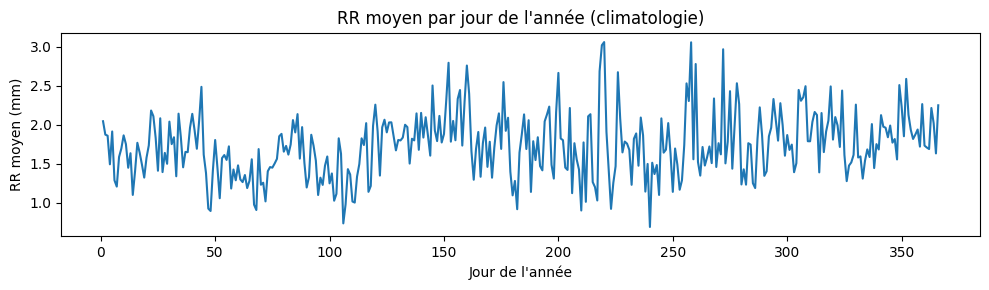

In [25]:
if "day_of_year" in df.columns and "RR" in df.columns:
    doy_rr = (df.dropna(subset=["day_of_year"])
                .groupby("day_of_year")["RR"]
                .mean()
                .sort_index())

    plt.figure(figsize=(10,3))
    plt.plot(doy_rr.index, doy_rr.values)
    plt.title("RR moyen par jour de l'année (climatologie)")
    plt.xlabel("Jour de l'année")
    plt.ylabel("RR moyen (mm)")
    plt.tight_layout()
    plt.show()


# 11. Corrélation Spearman des features avec RR\_j1

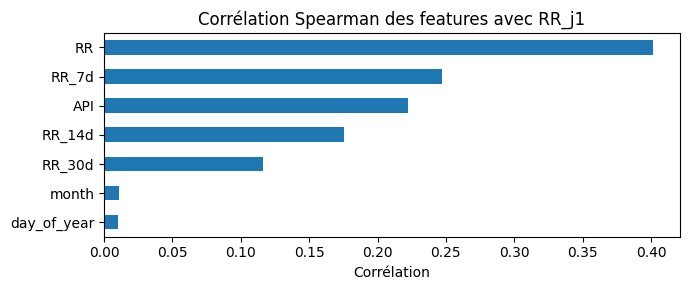

In [30]:
# Construction rapide de RR_j1 si NUM_POSTE et RR disponibles
if {"NUM_POSTE","RR","date"}.issubset(df.columns):
    tmp = df.sort_values(["NUM_POSTE","date"]).copy()
    tmp["RR_j1"] = tmp.groupby("NUM_POSTE")["RR"].shift(-1)

    feat_candidates = [
        "RR","RR_7d","RR_14d","RR_30d","API",
        "TM","TM_7d","TM_30d","TN","TX","PMER","FFM",
        "day_of_year","month","sin_doy","cos_doy"
    ]
    feats = [c for c in feat_candidates if c in tmp.columns]

    # échantillon pour rester léger
    sample_n = min(200_000, len(tmp))
    tsub = tmp[["RR_j1"] + feats].dropna().sample(sample_n, random_state=42) if len(tmp) > sample_n else tmp[["RR_j1"] + feats].dropna()

    # corrélation Spearman feature ↔ RR_j1
    corrs = tsub.corr(method="spearman")["RR_j1"].drop("RR_j1").sort_values()

    plt.figure(figsize=(7, max(3, 0.35*len(corrs))))
    corrs.plot(kind="barh")
    plt.title("Corrélation Spearman des features avec RR_j1")
    plt.xlabel("Corrélation")
    plt.tight_layout()
    plt.show()
else:
    print("Impossible de créer RR_j1 (NUM_POSTE/RR/date manquants).")


# 12. Matrice de corrélations Spearman (features météo/calendaires)

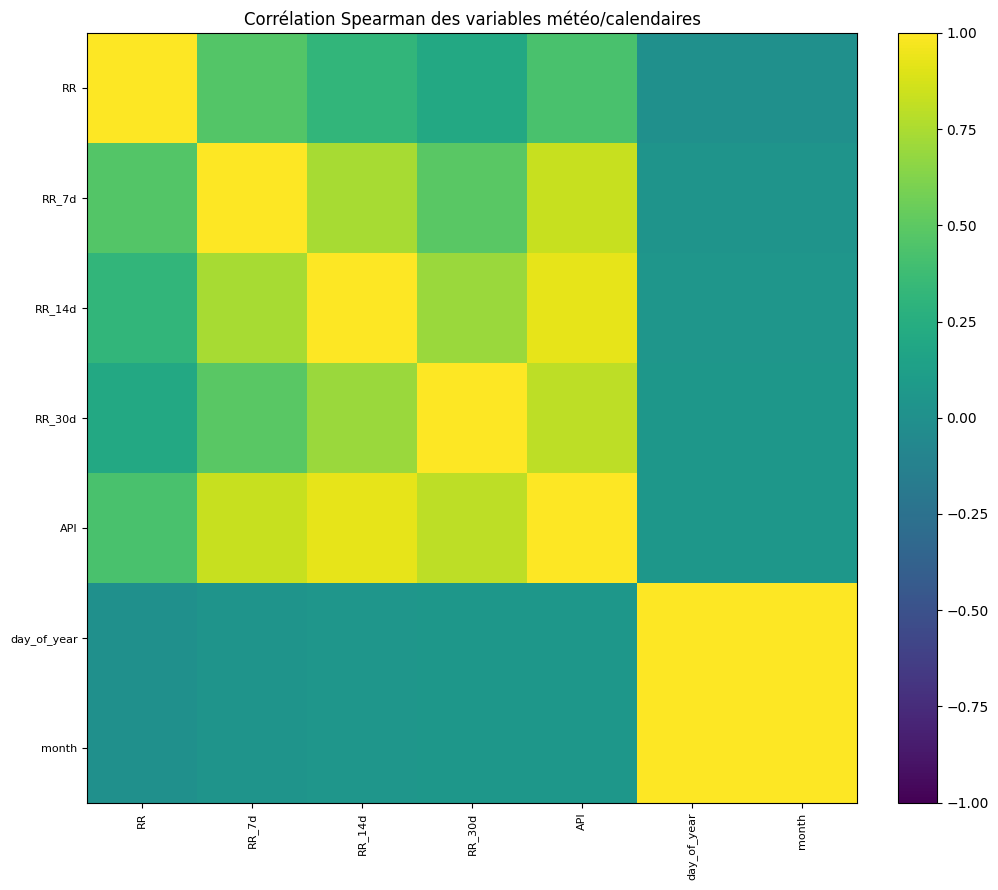

In [29]:
# Sélection de features numériques pertinentes si présentes
feat_candidates = [
    "RR","RR_7d","RR_14d","RR_30d","API",
    "TM","TM_7d","TM_30d","TN","TX",
    "PMER","FFM",
    "day_of_year","month","sin_doy","cos_doy"
]
cols = [c for c in feat_candidates if c in df.columns]

if len(cols) >= 2:
    # Échantillonnage pour éviter les soucis mémoire
    sample_n = min(250_000, len(df))
    dsub = df[cols].dropna().sample(sample_n, random_state=42) if len(df) > sample_n else df[cols].dropna()
    corr = dsub.corr(method="spearman")

    plt.figure(figsize=(min(1.0*len(cols)+4, 16), min(1.0*len(cols)+2, 14)))
    im = plt.imshow(corr.values, vmin=-1, vmax=1)
    plt.xticks(range(len(cols)), cols, rotation=90, fontsize=8)
    plt.yticks(range(len(cols)), cols, fontsize=8)
    plt.title("Corrélation Spearman des variables météo/calendaires")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("Trop peu de colonnes numériques pour calculer une corrélation.")
